# 朴素贝叶斯

### 杜小勤，武汉纺织大学数学与计算机学院，2020年02月20日
https://github.com/duxiaoqin/Lecture-notes-for-Machine-Learning

绘制高斯概率密度函数曲线

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

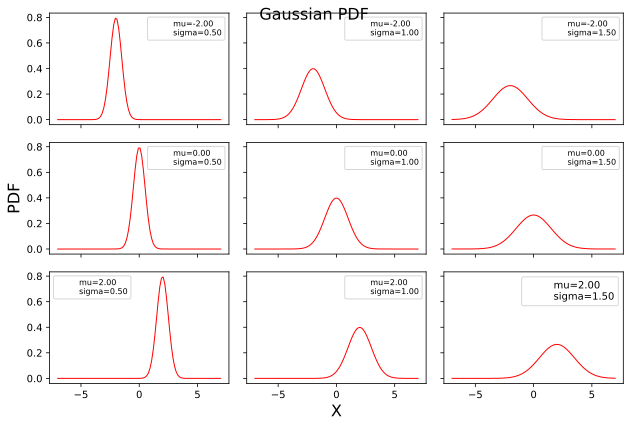

In [2]:
MU = [-2, 0, 2]
STD = [0.5, 1, 1.5]
X = np.linspace(-7, 7, 100)
fig, AX = plt.subplots(len(MU), len(STD), sharex = True, sharey = True, figsize = (9, 6))
for row in range(len(MU)):
  for col in range(len(STD)):
    mu = MU[row]
    std = STD[col]
    Y = stats.norm(mu, std).pdf(X) #高斯概率密度函数
    AX[row, col].plot(X, Y, 'r', linewidth = 1)
    AX[row, col].plot(0, 0, label='mu={:3.2f}\nsigma={:3.2f}'.format(mu, std), alpha = 0)
    AX[row, col].legend(fontsize = 8, loc = 'best')
AX[2, 1].set_xlabel('X', fontsize = 16)
AX[1, 0].set_ylabel('PDF', fontsize = 16)
plt.suptitle('Gaussian PDF', fontsize = 16)
plt.tight_layout()
plt.legend()
plt.savefig('NB_OUTPUT1.pdf', bbox_inches='tight')

定义高斯朴素贝叶斯模型

In [3]:
from collections import Counter

In [4]:
class GaussianNaiveBayes:
    def __init__(self):
        self.model = None
        
    #计算每列特征数据的高斯分布参数：均值与标准差
    def CalculateGaussian(self, data):
        return [(np.mean(feature), np.std(feature)) for feature in zip(*data)]
        
    #使用数据集对模型进行训练
    def fit(self, X, Y):
        labels_counter = Counter(Y) #提取出类标签及相应的样本个数
        self.labels_prob = {label:counter/len(Y) for label, counter in labels_counter.items()} #生成类标签概率
        dataset = {label:[] for label in labels_counter.keys()} #生成dataset字典数据，依类别存放各自的数据
        for x, y in zip(X, Y): #分类别重新存放训练数据
            dataset[y].append(x)
        self.features_prob = {label:self.CalculateGaussian(data) for label, data in dataset.items()} #依标签存放条件高斯概率分布P(X|C)的参数
        print('Gaussian Naive Bayes training done!')
        print('Label probability:', self.labels_prob)
        print('The parameters of features\' conditional probability:', self.features_prob)
        
    #给定X，预测类标签
    def predict(self, X):
        results = []
        for x in X:
            posterior = {}
            for label in self.labels_prob.keys():
                posterior[label] = self.labels_prob[label]
                for i_feature, mustd in enumerate(self.features_prob[label]):
                    posterior[label] *= stats.norm(mustd[0], mustd[1]).pdf(x[i_feature])
            results.append(sorted(posterior.items(), key = lambda x:x[-1])[-1][0]) #取出后验概率最大的类别
        return results

载入预存的鸢尾花数据集

In [5]:
iris_npz = np.load('iris.npz')
data = iris_npz['data']
X = iris_npz['X']
Y = iris_npz['Y']

绘制数据集中的数据

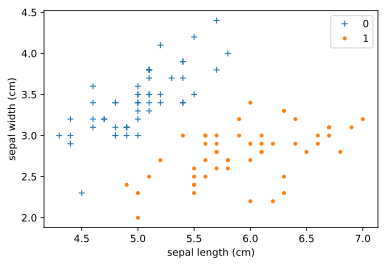

In [6]:
plt.plot(data[:50, 0], data[:50, 1], '+', label='0')
plt.plot(data[50:100, 0], data[50:100, 1], '.', label='1')
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend()
plt.savefig('NB_OUTPUT2.pdf', bbox_inches='tight')

使用鸢尾花数据集训练高斯朴素贝叶斯模型

In [7]:
model = GaussianNaiveBayes()
model.fit(X, Y)

Gaussian Naive Bayes training done!
Label probability: {0.0: 0.5, 1.0: 0.5}
The parameters of features' conditional probability: {0.0: [(5.0060000000000002, 0.3489469873777391), (3.4180000000000001, 0.37719490982779713)], 1.0: [(5.9359999999999999, 0.5109833656783751), (2.7700000000000005, 0.31064449134018135)]}


预测测试

In [8]:
XTEST = [(5.5, 2.8), (5.5, 3.5), (4.5, 3.5), (6.5, 2.5)]
results = model.predict(XTEST)
print(results)

[1.0, 0.0, 0.0, 1.0]


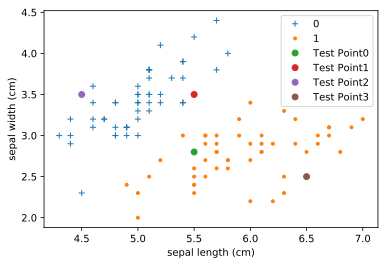

In [9]:
plt.plot(data[:50, 0], data[:50, 1], '+', label='0')
plt.plot(data[50:100, 0], data[50:100, 1], '.', label='1')
for i, point in enumerate(XTEST):
    plt.plot(point[0], point[1], 'o', label='Test Point{0}'.format(i))
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend()
plt.savefig('NB_OUTPUT3.pdf', bbox_inches='tight')

利用测试数据集进行测试，并计算正确率（Accuracy）

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
np.random.seed()
XTRAIN, XTEST, YTRAIN, YTEST = train_test_split(X, Y, test_size = 0.3)
model = GaussianNaiveBayes()
model.fit(XTRAIN, YTRAIN)
results = model.predict(XTEST)
scores = (results==YTEST)
print('Accuracy = {:3.2f}%'.format(Counter(scores)[True]/len(YTEST) * 100))

Gaussian Naive Bayes training done!
Label probability: {0.0: 0.5285714285714286, 1.0: 0.4714285714285714}
The parameters of features' conditional probability: {0.0: [(5.0162162162162165, 0.30180852486797044), (3.4027027027027028, 0.29269159720391097)], 1.0: [(5.8878787878787877, 0.48788819866700073), (2.7454545454545451, 0.32760925458762619)]}
Accuracy = 96.67%


使用鸢尾花数据集的所有数据，进行测试

In [12]:
import pandas as pd
from sklearn.datasets import load_iris

In [13]:
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns = iris.feature_names)
iris_df['label'] = iris.target
data = np.array(iris_df.iloc[:, :])
XALL, YALL = data[:, :-1], data[:, -1]
print(data.shape)
print(XALL.shape)
print(YALL.shape)

(150, 5)
(150, 4)
(150,)


保存数据集，以后可以直接使用

In [14]:
np.savez_compressed('iris_full.npz', data = data, X = XALL, Y = YALL)

利用测试数据集进行测试，并计算正确率（Accuracy）

In [15]:
np.random.seed()
XTRAIN, XTEST, YTRAIN, YTEST = train_test_split(XALL, YALL, test_size = 0.3)
model = GaussianNaiveBayes()
model.fit(XTRAIN, YTRAIN)
results = model.predict(XTEST)
scores = (results==YTEST)
print('Number of mislabeled points out of a total %d points : %d' % (len(YTEST), len(YTEST) - scores.sum()))
print('Accuracy = {:3.2f}%'.format(Counter(scores)[True]/len(YTEST) * 100))

Gaussian Naive Bayes training done!
Label probability: {0.0: 0.34285714285714286, 1.0: 0.3142857142857143, 2.0: 0.34285714285714286}
The parameters of features' conditional probability: {0.0: [(4.9972222222222236, 0.32273665831027615), (3.4027777777777781, 0.37229476904964481), (1.4833333333333334, 0.17078251276599329), (0.21944444444444444, 0.077529365205293688)], 1.0: [(5.9212121212121209, 0.54537036387437676), (2.7393939393939397, 0.34810255710968196), (4.2363636363636354, 0.51157403079194352), (1.3181818181818179, 0.21805551900007297)], 2.0: [(6.6527777777777786, 0.60712716547831103), (3.0194444444444439, 0.32302342918505017), (5.6055555555555552, 0.55474941512384401), (2.0500000000000003, 0.26718699236468996)]}
Number of mislabeled points out of a total 45 points : 3
Accuracy = 93.33%


使用sklearn.naive_bayes库

In [16]:
from sklearn.naive_bayes import GaussianNB

In [17]:
clf = GaussianNB()
clf.fit(XTRAIN, YTRAIN)

GaussianNB(priors=None)

In [18]:
print('Accuracy = {:3.2f}%'.format(clf.score(XTEST, YTEST) * 100))

Accuracy = 93.33%


随机生成训练数据集与测试数据集进行伯努利朴素贝叶斯模型的测试

In [19]:
from sklearn.naive_bayes import BernoulliNB

In [20]:
X = np.random.randint(2, size=(6, 100))
Y = np.array([1, 2, 3, 4, 5, 6])
clf = BernoulliNB()
clf.fit(X, Y)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [21]:
XTEST = np.random.randint(2, size=(4, 100))
print(clf.predict(XTEST))

[1 3 2 3]


使用随机数据集进行多项式朴素贝叶斯模型的测试

In [22]:
from sklearn.naive_bayes import MultinomialNB

In [23]:
X = np.random.randint(5, size=(6, 100))
Y = np.array([1, 2, 3, 4, 5, 6])
clf = MultinomialNB()
clf.fit(X, Y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [24]:
XTEST = np.random.randint(5, size=(2, 100))
print(clf.predict(XTEST))

[5 4]


参考文献：
- https://github.com/wzyonggege/statistical-learning-method;
- 《统计学习方法》第2版，李航；
- https://machinelearningmastery.com/naive-bayes-classifier-scratch-python/
- https://scikit-learn.org/stable/modules/naive_bayes.html
- https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
- https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html
- http://www.cnblogs.com/pinard/p/6069267.html
- Kevin P. Murphy. Machine Learning: A Probabilistic Perspective, The MIT Press, 2012.